## Loading and Preprocessing Data

In [50]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [51]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rahulsah06/gooogle-stock-price")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gooogle-stock-price' dataset.
Path to dataset files: /kaggle/input/gooogle-stock-price


In [52]:
# Importing the training set
dataset_train = pd.read_csv(path+"/Google_Stock_Price_Train.csv")

In [53]:
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [54]:
"Extracting only the Open price. Converting to a NumPy array. Shape becomes (number_of_days, 1)"
train = dataset_train.loc[:, ["Open"]].values
train

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [55]:
# Feature Scaling
"RNNs work better when inputs are in a small numerical range. Stock prices vary widely → scaling stabilizes training. Scales values to [0, 1]. "
"fit_transform learns min/max from training data and scales it"

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(train)
train_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

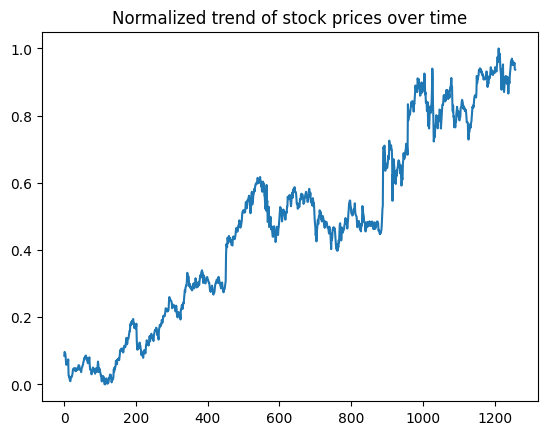

In [56]:
plt.plot(train_scaled)
plt.title("Normalized trend of stock prices over time")
plt.show()

In [57]:
# Creating a data structure with 50 timesteps and 1 output
X_train = []
y_train = []
timesteps = 50 # Each prediction uses the previous 50 days to predict the next day

for i in range(timesteps, 1258):
    X_train.append(train_scaled[i-timesteps:i, 0]) # sequences of 50 previous stock prices
    y_train.append(train_scaled[i, 0])             # the stock price immediately after those 50 days

X_train, y_train = np.array(X_train), np.array(y_train)

In [58]:
# Reshaping (for RNN input)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train # is in shape of (samples, timesteps, features) -> (number of training examples, 50, 1 feature=open price)

array([[[0.08581368],
        [0.09701243],
        [0.09433366],
        ...,
        [0.03675869],
        [0.04486941],
        [0.05065481]],

       [[0.09701243],
        [0.09433366],
        [0.09156187],
        ...,
        [0.04486941],
        [0.05065481],
        [0.05214302]],

       [[0.09433366],
        [0.09156187],
        [0.07984225],
        ...,
        [0.05065481],
        [0.05214302],
        [0.05612397]],

       ...,

       [[0.9313937 ],
        [0.94636878],
        [0.96569685],
        ...,
        [0.95475854],
        [0.95204256],
        [0.95163331]],

       [[0.94636878],
        [0.96569685],
        [0.97510976],
        ...,
        [0.95204256],
        [0.95163331],
        [0.95725128]],

       [[0.96569685],
        [0.97510976],
        [0.95966962],
        ...,
        [0.95163331],
        [0.95725128],
        [0.93796041]]])

In [59]:
y_train

array([0.05214302, 0.05612397, 0.05818885, ..., 0.95725128, 0.93796041,
       0.93688146])

## Create RNN Model

In [60]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout


# Initialising the RNN
regressor = Sequential()

# 1st RNN layer with some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.4))

# 2nd RNN layer with some Dropout regularisation. Units = neurons. return_sequences needed as another RNN follows
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.4))

# 3rd RNN layer with some Dropout regularisation. Deep RNN structure improves pattern learning over time
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.4))

# A final 4th RNN layer with some Dropout regularisation. return_sequences is false as outputs only the last timestep
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.4))

# Output layer - predicts next day's stock price
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 1.1393
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.6858
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.4264
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.3685
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.3034
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.2250
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1955
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.1841
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.1489
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.1275
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.1080
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0910
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0803
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0743
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - lo

## Predictions and Visualising RNN Model

In [61]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv(path+'/Google_Stock_Price_Test.csv')
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [62]:
# Ground truth for comparison
real_stock_price = dataset_test.loc[:, ["Open"]].values
real_stock_price

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

In [63]:
# Getting the predicted stock price of 2017.
"Predictions for day t need the previous 50 days. Some of those days come from training data"

dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values.reshape(-1,1)
inputs = scaler.transform(inputs)  # min max scaler
inputs


array([[0.97510976],
       [0.95966962],
       [0.97808617],
       [1.        ],
       [0.98076494],
       [0.97083116],
       [0.98450406],
       [0.96054394],
       [0.9371419 ],
       [0.92841729],
       [0.90804747],
       [0.8771858 ],
       [0.92153434],
       [0.93809063],
       [0.93165414],
       [0.95254483],
       [0.88812412],
       [0.88637547],
       [0.87032145],
       [0.88563137],
       [0.90743359],
       [0.91571173],
       [0.89941588],
       [0.91805566],
       [0.9089404 ],
       [0.9024853 ],
       [0.89456061],
       [0.91600938],
       [0.9132934 ],
       [0.88979835],
       [0.86589404],
       [0.89030062],
       [0.90335962],
       [0.89642086],
       [0.91777662],
       [0.93176576],
       [0.94114145],
       [0.95762334],
       [0.96413424],
       [0.96402262],
       [0.96971501],
       [0.95077759],
       [0.96294367],
       [0.96123223],
       [0.95475854],
       [0.95204256],
       [0.95163331],
       [0.957

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


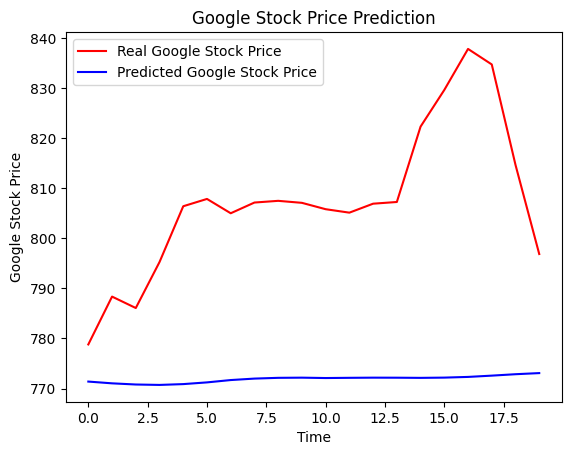

In [64]:
# Creates sliding windows just like training data. 70 corresponds to number of test days.
X_test = []
for i in range(timesteps, 70):
    X_test.append(inputs[i-timesteps:i, 0])

# Reshaped for RNN input.
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)

# Predictions are scaled back to original price values
predicted_stock_price = predicted_stock_price.reshape(-1, 1)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


# Visualising the results -> how well the model follows the real trend?
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


## Assignment
Try to improve the result! Document your actions and conclusions further in this notebook.

Assignment:

To improve the model I experimented with different layer and unit combinations and tested both SimpleRNN and LSTM architectures, and changed the dropout rate.

- Increasing layers or units did not always improve performance, sometimes predictions became less accurate or almost constant.

- LSTM layers performed much better than SimpleRNN, especially for capturing trends in the data.

- A higher dropout rate (0.4) reduced overfitting, but too high dropout with SimpleRNN led to poor learning.

Overall, careful tuning of architecture and hyperparameters is essential. LSTM with moderate dropout gave the best results for this dataset.

I based my analysis and conclusions on the results and outputs shown below, which reflect the experiments I performed to improve the model;


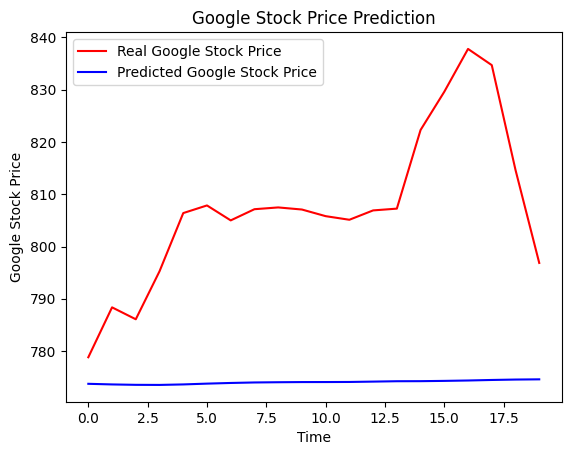

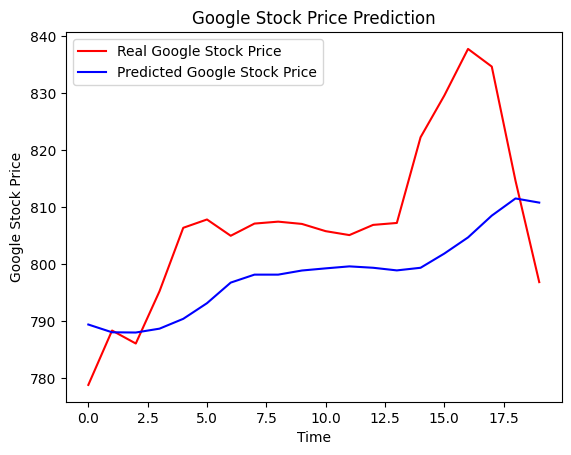

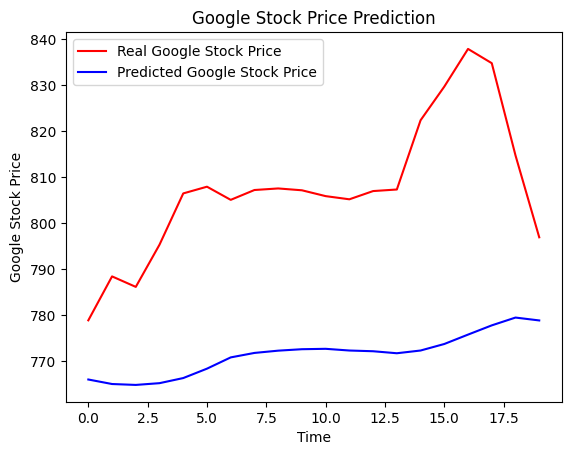

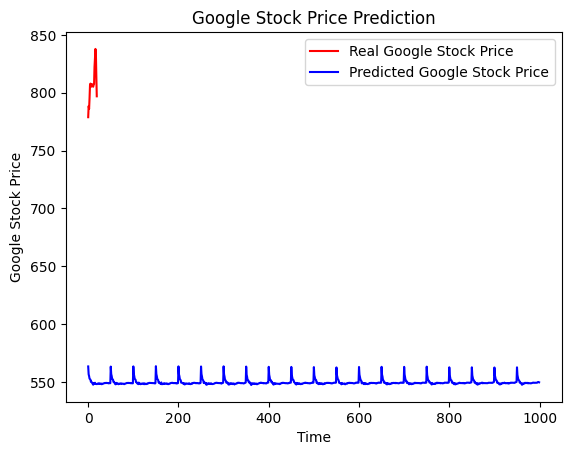

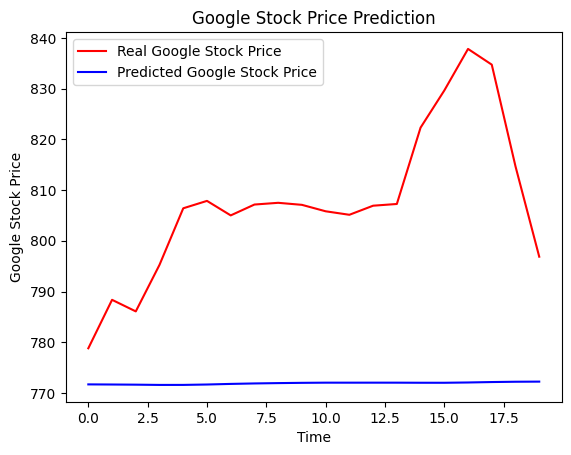

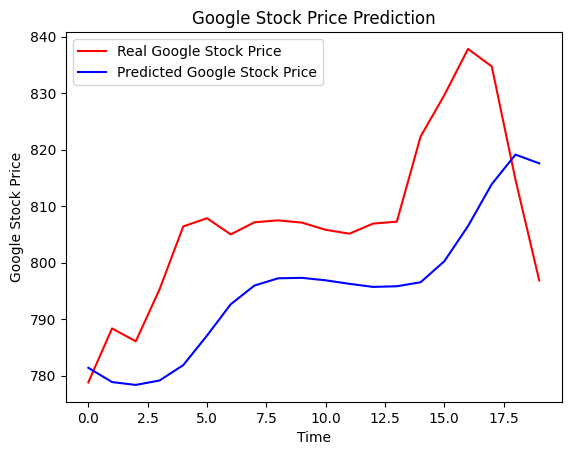

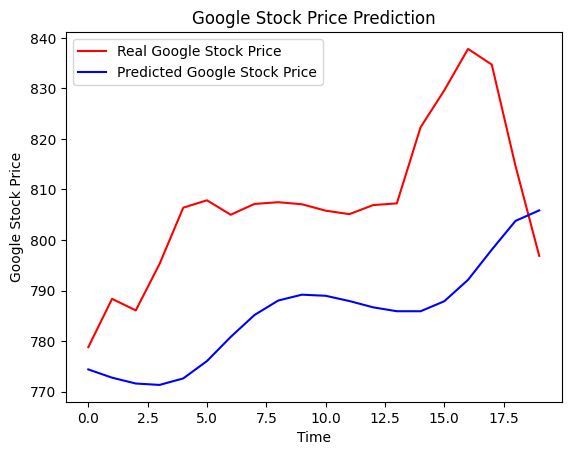

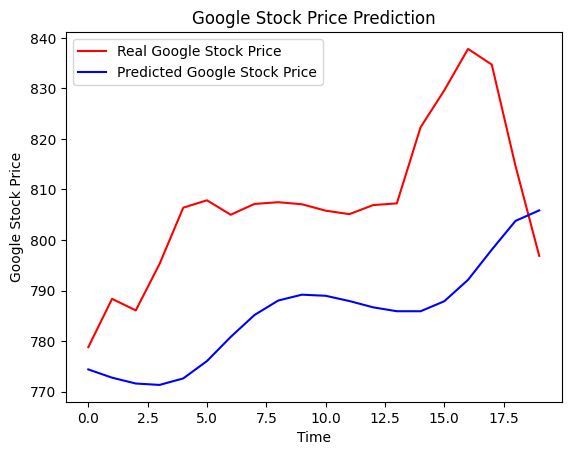

#### License
This Notebook has been released under the Apache 2.0 open source license.

https://www.kaggle.com/code/moonglow22/rnn-and-lstm-tutorial-for-beginners/notebook